DenseNet（Densely Connected Convolutional Network）是2017年提出的一种卷积神经网络架构，通过**密集连接（Dense Connection）** 彻底改变了网络层之间的信息流动方式。与传统CNN（如VGG、ResNet）相比，DenseNet的核心创新在于：**每一层都直接连接到后续的所有层**，形成“密集块”（Dense Block），从而显著提升了特征复用能力，减少了参数量，并缓解了梯度消失问题。


### 一、DenseNet的核心思想：密集连接
传统CNN中，第$l$层的输入仅来自第$l-1$层的输出，形成线性链结构；而在DenseNet中，第$l$层的输入包含前面所有层的输出：  
$$x_l = H_l([x_0, x_1, ..., x_{l-1}])$$  
其中：
- $x_0, x_1, ..., x_{l-1}$ 是前面所有层的特征图。
- $[x_0, x_1, ..., x_{l-1}]$ 表示特征图在通道维度上的拼接（Concatenation）。
- $H_l(\cdot)$ 是一个复合函数（通常包含BatchNorm、ReLU和卷积层）。


### 二、DenseNet的关键组件
#### 1. 密集块（Dense Block）
- 由多个卷积层（称为“层”）组成，每一层的输出都会与前面所有层的输出拼接，作为后续层的输入。
- 特征图通道数随层数增长，因此需要控制每层输出的通道数（称为“增长率”，记为$k$）。例如，若增长率$k=32$，则第$l$层的输入通道数为$k_0 + k \times (l-1)$（$k_0$为初始通道数）。

#### 2. 过渡层（Transition Layer）
- 位于两个密集块之间，用于减小特征图尺寸和通道数，防止通道数爆炸。
- 通常包含：1x1卷积（压缩通道数）+ 2x2平均池化（降采样）。

#### 3. Bottleneck层
- 为减少计算量，在每个卷积层前添加1x1卷积作为瓶颈层，先将输入通道数压缩（如从$k \times (l-1)$压缩到$4k$），再进行3x3卷积。
- 完整的层结构：`BN → ReLU → 1x1 Conv → BN → ReLU → 3x3 Conv`。


### 三、DenseNet的优势
1. **缓解梯度消失**  
   密集连接使梯度可通过多条路径反向传播，即使网络很深，梯度也能有效传递到浅层。

2. **减少参数数量**  
   由于特征复用，不需要重复学习相似特征，参数量显著少于传统CNN（如ResNet）。

3. **增强特征传播与复用**  
   早期层的特征可直接传递到后续层，避免信息丢失，尤其适合提取细粒度特征（如图像分割任务）。

4. **正则化效果**  
   密集连接增加了网络的复杂性，但也通过特征复用隐式实现了正则化，减少过拟合风险。


### 四、DenseNet与ResNet的对比
| 特性                | ResNet                         | DenseNet                       |
|---------------------|--------------------------------|--------------------------------|
| **连接方式**        | 跳跃连接（加法：$x + F(x)$）   | 密集连接（拼接：$[x_0, x_1, ...]$） |
| **信息流动**        | 残差学习，保留原始信息         | 特征复用，所有层共享信息       |
| **梯度传播**        | 单一路径（通过加法）           | 多条路径（通过拼接）           |
| **参数量**          | 较高（每层需学习完整特征）     | 较低（依赖特征复用）           |
| **特征图尺寸**      | 逐层变化（通过步长卷积降采样） | 密集块内不变，过渡层降采样     |


### 五、DenseNet的典型架构
常见的DenseNet版本有DenseNet-121、169、201、264等，数字代表网络总层数。以DenseNet-121为例，其结构为：
1. **初始卷积层**：7x7卷积（64通道，步长2）+ 3x3最大池化（步长2）。
2. **密集块与过渡层**：  
   - 密集块1：6层，增长率$k=32$ → 过渡层1（通道压缩至128，降采样）。  
   - 密集块2：12层 → 过渡层2（通道压缩至256，降采样）。  
   - 密集块3：24层 → 过渡层3（通道压缩至512，降采样）。  
   - 密集块4：16层。  
3. **全局平均池化**：将特征图压缩为1x1向量。  
4. **全连接层**：分类输出（如ImageNet的1000类）。


### 六、DenseNet的应用场景
1. **图像分类**：在ImageNet等基准测试中达到SOTA性能。
2. **图像分割**：通过特征复用保留细粒度信息，如FC-DenseNet。
3. **医学图像分析**：适合小样本下的疾病诊断（如癌细胞检测）。
4. **生成模型**：在GAN中作为生成器或判别器，提升图像质量。


### 七、总结
DenseNet通过密集连接彻底重构了CNN的信息流，既解决了深层网络的梯度消失问题，又显著减少了参数量。其核心创新在于**特征的充分复用**，使网络能够更高效地学习和传递信息。尽管计算复杂度较高（因频繁拼接操作），但DenseNet的思想已被广泛应用于后续网络（如EfficientNet、ConvNeXt），成为深度学习领域的重要基石。

## densenet的block结构 

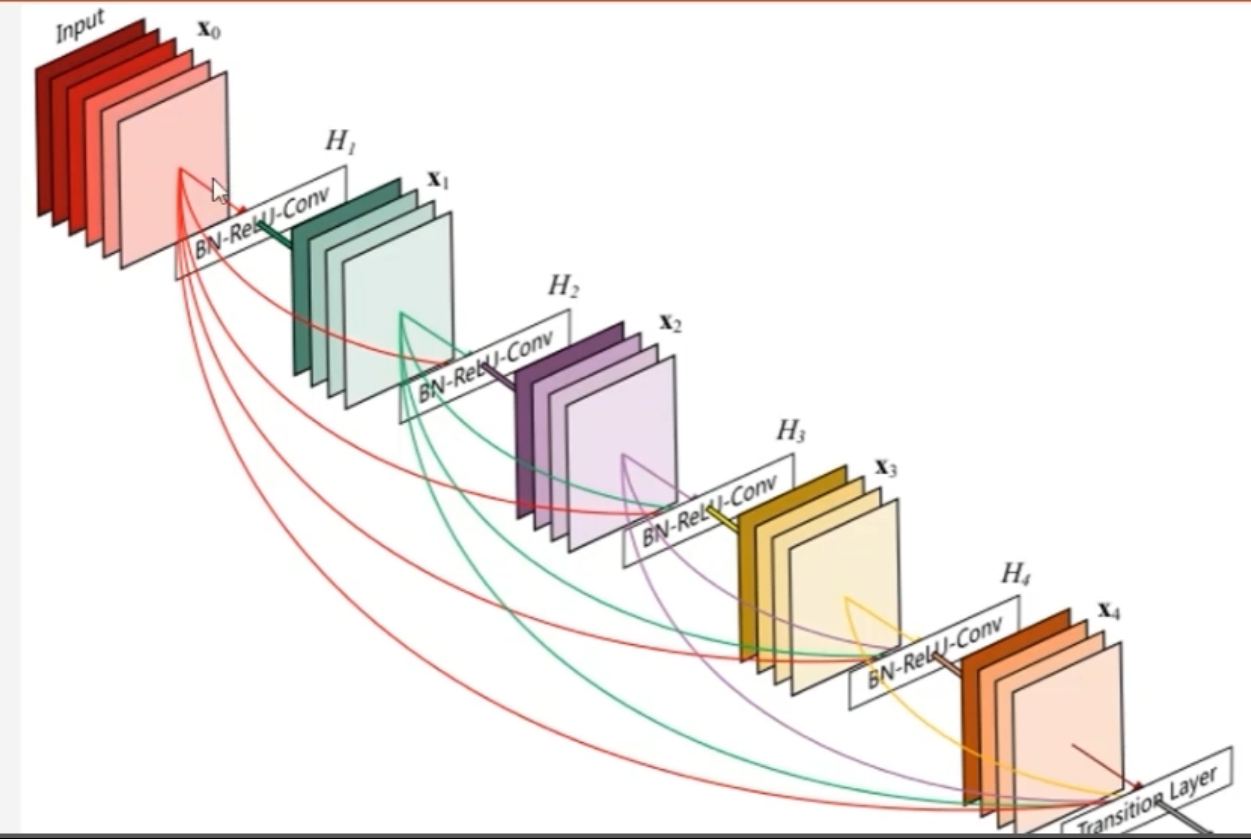

DenseNetBlock（密集块）是DenseNet（密集连接卷积网络）的核心组件，它通过**密集连接（Dense Connection）** 机制彻底改变了传统卷积神经网络的信息流结构。与ResNet的跳跃连接（Skip Connection）不同，DenseNetBlock中的**每一层都直接连接到后续的所有层**，形成特征复用的“密集”网络，显著提升了特征传播效率和模型性能。


### 一、DenseNetBlock的核心思想
传统CNN中，第$l$层的输入仅来自第$l-1$层的输出（即$x_l = H_l(x_{l-1})$）；而在DenseNetBlock中，第$l$层的输入包含前面**所有层的输出**：  
$$x_l = H_l([x_0, x_1, ..., x_{l-1}])$$  
其中：
- $[x_0, x_1, ..., x_{l-1}]$ 表示将前面所有层的特征图在**通道维度上拼接**（Concatenation）。
- $H_l(\cdot)$ 是一个复合函数，通常包含**BatchNorm → ReLU → Conv**操作。


### 二、DenseNetBlock的关键结构
#### 1. 基本组成单元：Bottleneck层
为减少计算量，DenseNetBlock中的每一层采用**Bottleneck设计**：  
- **1x1卷积**：先将输入通道数压缩（如从$k \times (l-1)$压缩到$4k$），称为“瓶颈”。  
- **3x3卷积**：在低维度上进行特征提取，输出$k$个通道（$k$称为**增长率**，通常取12、24、32等）。  

完整结构为：  
```plaintext
输入 → BN → ReLU → 1x1 Conv(4k) → BN → ReLU → 3x3 Conv(k) → 输出
```

#### 2. 密集连接机制
- 假设一个DenseNetBlock有$L$层，每层输出$k$个通道，则第$l$层的输入通道数为：  
  $$k_0 + k \times (l-1)$$  
  其中$k_0$为初始通道数。  
- 随着层数增加，输入通道数线性增长，但由于增长率$k$通常较小（如32），整体参数量仍可控。


### 三、DenseNetBlock的优势
1. **特征复用最大化**  
   早期层的特征直接传递到后续所有层，避免信息丢失，尤其适合提取细粒度特征。

2. **缓解梯度消失**  
   梯度可通过多条路径反向传播（从任意输出层直接连接到所有前层），即使网络很深也能保持梯度流动。

3. **参数效率高**  
   无需重复学习相似特征，参数量显著少于传统CNN（如ResNet）。

4. **正则化效果**  
   密集连接增加了网络复杂度，但通过特征复用隐式实现正则化，减少过拟合风险。


### 四、DenseNetBlock与ResNet残差块的对比
| 特性                | ResNet残差块                     | DenseNetBlock                    |
|---------------------|----------------------------------|----------------------------------|
| **连接方式**        | 跳跃连接（加法：$x + F(x)$）     | 密集连接（拼接：$[x_0, x_1, ...]$） |
| **信息流动**        | 保留原始信息，学习残差           | 共享所有层的特征，无信息丢失     |
| **梯度传播路径**    | 单一路径（通过加法）             | 多条路径（直接连接所有前层）     |
| **通道数变化**      | 可能通过1x1卷积调整通道数         | 逐层线性增长（通道数=$k_0 + k \times l$） |
| **计算复杂度**      | 较低（仅需处理当前层输出）       | 较高（需拼接所有前层输出）       |


### 五、DenseNet中的DenseNetBlock组织
一个完整的DenseNet通常由多个DenseNetBlock和**过渡层（Transition Layer）** 交替组成：
1. **DenseNetBlock**：内部密集连接，特征图尺寸不变，通道数逐层增加。  
2. **过渡层**：位于两个DenseNetBlock之间，包含：  
   - **1x1卷积**：压缩通道数（通常减少50%）。  
   - **2x2平均池化**：将特征图尺寸减半。  

例如，DenseNet-121的网络结构为：  
```plaintext
输入 → 初始卷积 → [DenseBlock1(6层) → 过渡层1] → [DenseBlock2(12层) → 过渡层2] → 
[DenseBlock3(24层) → 过渡层3] → DenseBlock4(16层) → 全局平均池化 → 全连接分类
```


### 六、总结
DenseNetBlock通过密集连接机制，实现了特征的最大化复用和高效传播，是DenseNet架构的核心创新。其设计思想不仅提升了模型性能，还为后续网络（如EfficientNet、ConvNeXt）提供了重要启发。在实际应用中，DenseNetBlock特别适合需要细粒度特征的任务（如图像分割、医学图像分析），以及数据有限场景下的模型训练。 

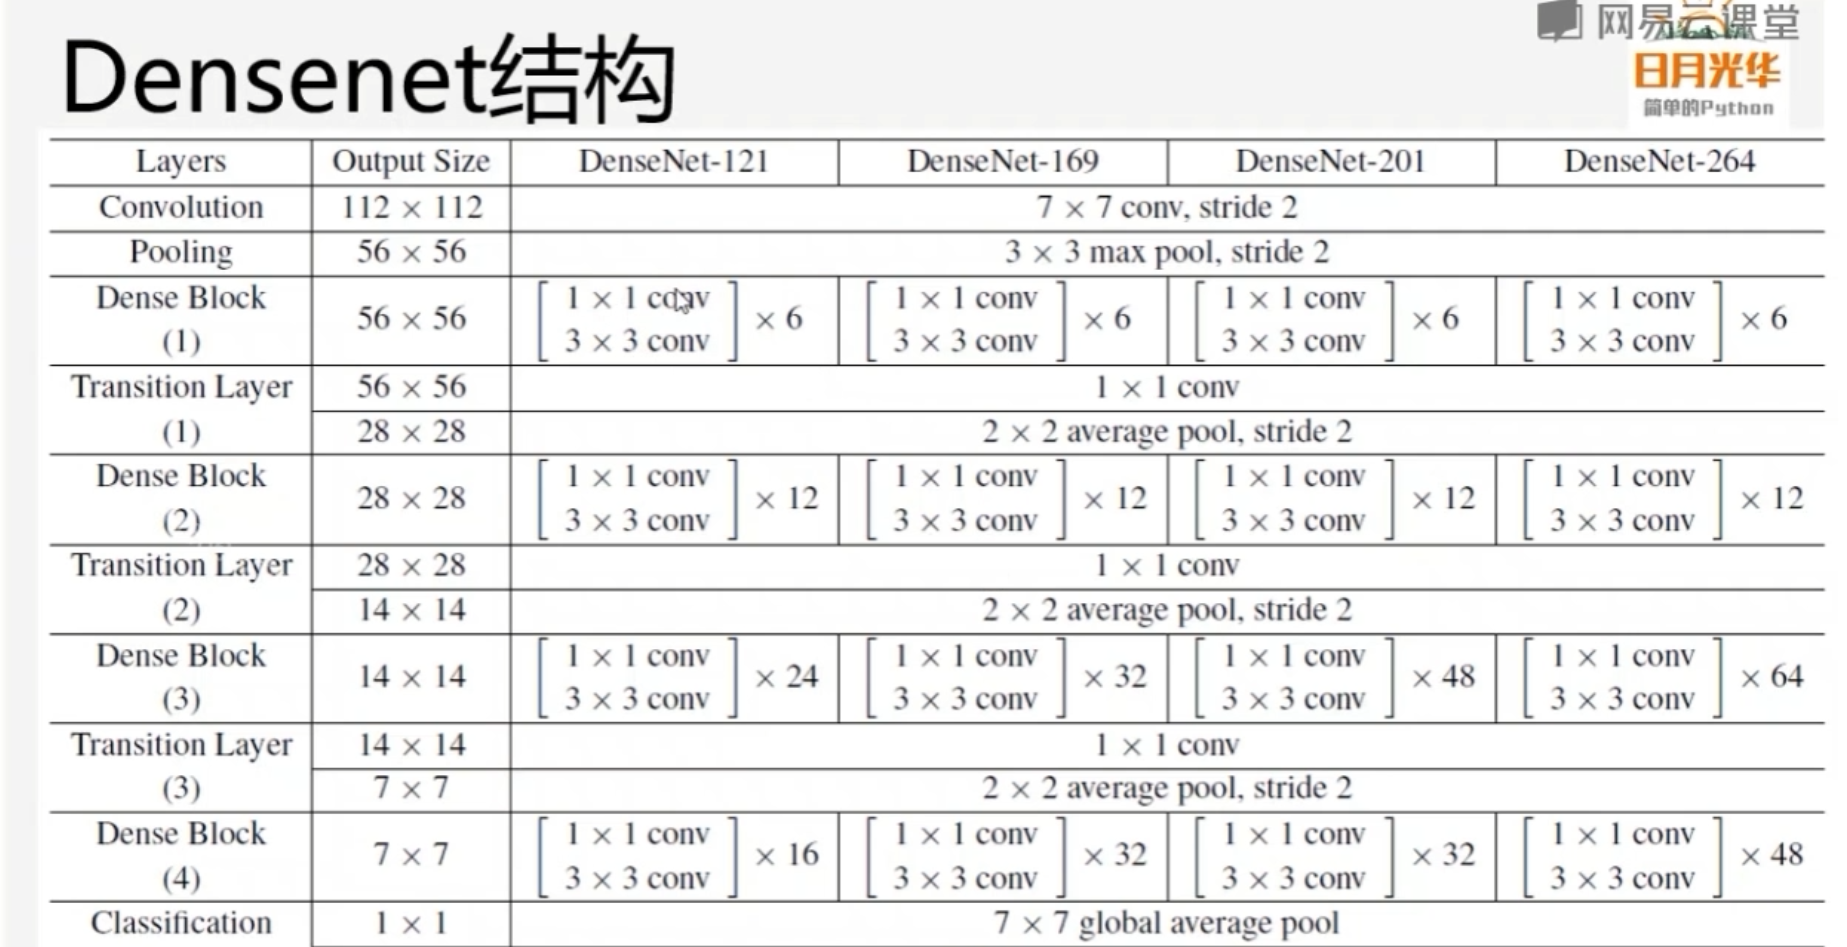

# 使用densenet提取图片特征 

In [1]:
import torch 
import torchvision
from torchvision import transforms 

In [2]:
from torch.utils.data import DataLoader,Dataset 
import matplotlib.pyplot as plt
from PIL import Image
import glob

## 获取图片  

In [3]:
img_path = glob.glob('birds/*/*.jpg')

In [4]:
img_path[:5]

['birds\\001.Black_footed_Albatross\\Black_Footed_Albatross_0001_796111.jpg',
 'birds\\001.Black_footed_Albatross\\Black_Footed_Albatross_0002_55.jpg',
 'birds\\001.Black_footed_Albatross\\Black_Footed_Albatross_0003_796136.jpg',
 'birds\\001.Black_footed_Albatross\\Black_Footed_Albatross_0005_796090.jpg',
 'birds\\001.Black_footed_Albatross\\Black_Footed_Albatross_0006_796065.jpg']

In [5]:
img_path[0].split('\\')[1].split('.')[1] 

'Black_footed_Albatross'

In [6]:
all_labelname=[] 
for im in img_path: 
    label = im.split('\\')[1].split('.')[1] 
    all_labelname.append(label)

In [7]:
all_labelname[:20]

['Black_footed_Albatross',
 'Black_footed_Albatross',
 'Black_footed_Albatross',
 'Black_footed_Albatross',
 'Black_footed_Albatross',
 'Black_footed_Albatross',
 'Black_footed_Albatross',
 'Black_footed_Albatross',
 'Black_footed_Albatross',
 'Black_footed_Albatross',
 'Black_footed_Albatross',
 'Black_footed_Albatross',
 'Black_footed_Albatross',
 'Black_footed_Albatross',
 'Black_footed_Albatross',
 'Black_footed_Albatross',
 'Black_footed_Albatross',
 'Black_footed_Albatross',
 'Black_footed_Albatross',
 'Black_footed_Albatross']

In [8]:
all_labelname[-5:] 

['Common_Yellowthroat',
 'Common_Yellowthroat',
 'Common_Yellowthroat',
 'Common_Yellowthroat',
 'Common_Yellowthroat']

In [9]:
import numpy as np
unique_labels = np.unique(all_labelname)
unique_labels

array(['Acadian_Flycatcher', 'American_Crow', 'American_Goldfinch',
       'American_Pipit', 'American_Redstart',
       'American_Three_toed_Woodpecker', 'Anna_Hummingbird', 'Artic_Tern',
       'Baird_Sparrow', 'Baltimore_Oriole', 'Bank_Swallow',
       'Barn_Swallow', 'Bay_breasted_Warbler', 'Belted_Kingfisher',
       'Bewick_Wren', 'Black_Tern', 'Black_and_white_Warbler',
       'Black_billed_Cuckoo', 'Black_capped_Vireo',
       'Black_footed_Albatross', 'Black_throated_Blue_Warbler',
       'Black_throated_Sparrow', 'Blue_Grosbeak', 'Blue_Jay',
       'Blue_headed_Vireo', 'Blue_winged_Warbler', 'Boat_tailed_Grackle',
       'Bobolink', 'Bohemian_Waxwing', 'Brandt_Cormorant',
       'Brewer_Blackbird', 'Brewer_Sparrow', 'Bronzed_Cowbird',
       'Brown_Creeper', 'Brown_Pelican', 'Brown_Thrasher', 'Cactus_Wren',
       'California_Gull', 'Canada_Warbler', 'Cape_Glossy_Starling',
       'Cape_May_Warbler', 'Cardinal', 'Carolina_Wren', 'Caspian_Tern',
       'Cedar_Waxwing', 'Cerule

In [10]:
len(unique_labels)

200

In [11]:
label_to_index = dict((v,k) for k,v in enumerate(unique_labels)) 
label_to_index

{'Acadian_Flycatcher': 0,
 'American_Crow': 1,
 'American_Goldfinch': 2,
 'American_Pipit': 3,
 'American_Redstart': 4,
 'American_Three_toed_Woodpecker': 5,
 'Anna_Hummingbird': 6,
 'Artic_Tern': 7,
 'Baird_Sparrow': 8,
 'Baltimore_Oriole': 9,
 'Bank_Swallow': 10,
 'Barn_Swallow': 11,
 'Bay_breasted_Warbler': 12,
 'Belted_Kingfisher': 13,
 'Bewick_Wren': 14,
 'Black_Tern': 15,
 'Black_and_white_Warbler': 16,
 'Black_billed_Cuckoo': 17,
 'Black_capped_Vireo': 18,
 'Black_footed_Albatross': 19,
 'Black_throated_Blue_Warbler': 20,
 'Black_throated_Sparrow': 21,
 'Blue_Grosbeak': 22,
 'Blue_Jay': 23,
 'Blue_headed_Vireo': 24,
 'Blue_winged_Warbler': 25,
 'Boat_tailed_Grackle': 26,
 'Bobolink': 27,
 'Bohemian_Waxwing': 28,
 'Brandt_Cormorant': 29,
 'Brewer_Blackbird': 30,
 'Brewer_Sparrow': 31,
 'Bronzed_Cowbird': 32,
 'Brown_Creeper': 33,
 'Brown_Pelican': 34,
 'Brown_Thrasher': 35,
 'Cactus_Wren': 36,
 'California_Gull': 37,
 'Canada_Warbler': 38,
 'Cape_Glossy_Starling': 39,
 'Cape_May_

In [12]:
index_to_label = dict((v,k) for k,v in label_to_index.items())
index_to_label

{0: 'Acadian_Flycatcher',
 1: 'American_Crow',
 2: 'American_Goldfinch',
 3: 'American_Pipit',
 4: 'American_Redstart',
 5: 'American_Three_toed_Woodpecker',
 6: 'Anna_Hummingbird',
 7: 'Artic_Tern',
 8: 'Baird_Sparrow',
 9: 'Baltimore_Oriole',
 10: 'Bank_Swallow',
 11: 'Barn_Swallow',
 12: 'Bay_breasted_Warbler',
 13: 'Belted_Kingfisher',
 14: 'Bewick_Wren',
 15: 'Black_Tern',
 16: 'Black_and_white_Warbler',
 17: 'Black_billed_Cuckoo',
 18: 'Black_capped_Vireo',
 19: 'Black_footed_Albatross',
 20: 'Black_throated_Blue_Warbler',
 21: 'Black_throated_Sparrow',
 22: 'Blue_Grosbeak',
 23: 'Blue_Jay',
 24: 'Blue_headed_Vireo',
 25: 'Blue_winged_Warbler',
 26: 'Boat_tailed_Grackle',
 27: 'Bobolink',
 28: 'Bohemian_Waxwing',
 29: 'Brandt_Cormorant',
 30: 'Brewer_Blackbird',
 31: 'Brewer_Sparrow',
 32: 'Bronzed_Cowbird',
 33: 'Brown_Creeper',
 34: 'Brown_Pelican',
 35: 'Brown_Thrasher',
 36: 'Cactus_Wren',
 37: 'California_Gull',
 38: 'Canada_Warbler',
 39: 'Cape_Glossy_Starling',
 40: 'Cape_

In [13]:
all_labels = [label_to_index.get(name) for name in all_labelname]
all_labels

[19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 99,
 99,
 99,
 99,
 99,
 99,
 99,
 99,
 99,
 99,
 99,
 99,
 99,
 99,
 99,
 99,
 99,
 99,
 99,
 99,
 99,
 99,
 99,
 99,
 99,
 99,
 99,
 99,
 99,
 99,
 99,
 99,
 99,
 99,
 99,
 99,
 99,
 99,
 99,
 99,
 99,
 99,
 99,
 99,
 99,
 99,
 99,
 99,
 99,
 99,
 99,
 99,
 99,
 99,
 99,
 99,
 99,
 99,
 99,
 99,
 168,
 168,
 168,
 168,
 168,
 168,
 168,
 168,
 168,
 168,
 168,
 168,
 168,
 168,
 168,
 168,
 168,
 168,
 168,
 168,
 168,
 168,
 168,
 168,
 168,
 168,
 168,
 168,
 168,
 168,
 168,
 168,
 168,
 168,
 168,
 168,
 168,
 168,
 168,
 168,
 168,
 168,
 168,
 168,
 168,
 168,
 168,
 168,
 168,
 168,
 168,
 168,
 168,
 168,
 168,
 168,
 168,
 168,
 83,
 83,
 83,
 83,
 83,
 83,
 83,
 83,
 83,
 83,
 8

In [14]:
all_labels[:5]

[19, 19, 19, 19, 19]

In [15]:
all_labels[-5:]

[54, 54, 54, 54, 54]

In [16]:
len(img_path)

11788

## 划分训练集和测试集  

In [17]:
np.random.seed(2025) 
randomindex = np.random.permutation(len(img_path)) #产生乱序的index 

### 乱序 

In [18]:
img_path = np.array(img_path)[randomindex]
all_labels = np.array(all_labels)[randomindex] 

In [19]:
i=int(len(img_path)*0.8)
i

9430

###  进行划分

In [20]:
train_path = img_path[:i]
train_label = all_labels[:i]

In [21]:
test_path = img_path[i:]
test_label = all_labels[i:]

## 创建dataset  

In [22]:
transform_train = transforms.Compose(
    [
        transforms.Resize((224,224)), 
        transforms.ColorJitter(brightness=0.5,contrast=0.5), 
        transforms.RandomHorizontalFlip(), 
        transforms.RandomRotation(degrees=20),
        transforms.ToTensor(), 
    ]
)

In [23]:
transform_test = transforms.Compose(
    [
        transforms.Resize((224,224)), 
        transforms.ToTensor()
    ]
)

In [24]:
from PIL import Image
class customized_dataset(Dataset): 
    def __init__(self,img_path,labels,transform):
        self.img_path = img_path
        self.labels = labels
        self.transform = transform
        pass
    def __len__(self): 
        return len(self.img_path)
    def __getitem__(self,index): 
        img = self.img_path[index]
        label = self.labels[index]

        img = Image.open(img).convert('RGB') 
        if self.transform:
            img = self.transform(img)
        return img,label
            
        
        

### 创建dataset  

In [25]:
train_ds = customized_dataset(img_path=train_path,labels=train_label,transform=transform_train) 
test_ds = customized_dataset(img_path=test_path,labels=test_label,transform=transform_test)

### 创建dataloader

In [26]:
train_dl = DataLoader(train_ds,batch_size=32) 
test_dl = DataLoader(test_ds,batch_size=64)

In [27]:
img_batch,label_batch = next(iter(train_dl))

In [28]:
img_batch

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
        

In [29]:
label_batch

tensor([ 22,  31, 175, 136,  68,  35, 103,  69, 164,  48, 150,  48,  61, 198,
        148, 165,   0, 143,  84,  74, 178,  68, 127,  83,  10, 102,  15, 161,
         58,  39, 125, 162], dtype=torch.int32)

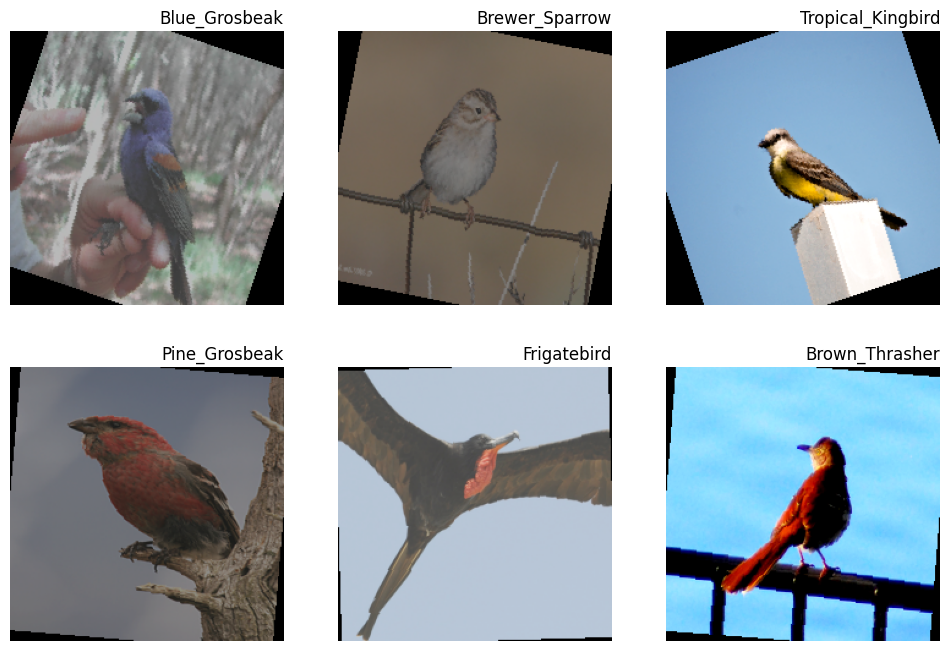

In [30]:
plt.figure(figsize=(12,8)) 
for idx,(iMg,lAbel) in enumerate(zip(img_batch[:6],label_batch[:6])):
    iMg = iMg.permute(1,2,0).numpy() #将chanel放在后面
    plt.subplot(2,3,idx+1)
    plt.title(index_to_label[lAbel.item()],loc='right') 
    plt.axis('off')
    plt.imshow(iMg)

In [31]:
model = torchvision.models.densenet121(weights=torchvision.models.DenseNet121_Weights.IMAGENET1K_V1)

In [32]:
model

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

### 使用densenet的卷积基部分提取特征  

In [43]:
model = model.features

In [44]:
for param in model.parameters():  
    param.requires_grad = False
    

In [45]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
train_features=[] 
train_features_labels = [] 
for img,label in train_dl: 
    out = model(img.cuda())
    out = torch.flatten(out,1)
    train_features.extend(out.cpu().detach())
    train_features_labels.extend(label)


test_features=[] 
test_features_labels = [] 
for img,label in test_dl: 
    out = model(img.cuda())
    out = torch.flatten(out,1)
    test_features.extend(out.cpu().detach())
    test_features_labels.extend(label)

In [46]:
len(train_features)

9430

In [47]:
train_features[0].shape

torch.Size([50176])

### 创建新的dataset  

In [48]:
class feature_dataset(Dataset): 
    def __init__(self,feature_lst,label_lst): 
        self.feature_lst = feature_lst
        self.label_lst = label_lst
    def __getitem__(self,index): 
        return self.feature_lst[index],self.label_lst[index]
    def __len__(self): 
        return len(self.feature_lst)

In [49]:
train_features_ds = feature_dataset(train_features,train_features_labels)
test_features_ds = feature_dataset(test_features,test_features_labels)

In [52]:
train_features_dl = DataLoader(train_features_ds,batch_size=32,shuffle=True)
test_features_dl = DataLoader(test_features_ds,batch_size=64)

### 因为我们是用densenet的卷积基部分做的特征提取,现在我们只需要定义一个最终的全连接层用来最后的分类即可

In [53]:
infeature_size = train_features[0].shape
infeature_size

torch.Size([50176])

In [54]:
infeature_size = train_features[0].shape[0] 
infeature_size

50176

In [55]:
class FCModel(torch.nn.Module): 
    def __init__(self,in_features_size,output_features_size): 
        super().__init__() 
        self.liner = torch.nn.Linear(in_features=infeature_size,out_features=output_features_size)
    def forward(self,input): 
        return self.liner(input)

In [56]:
net = FCModel(infeature_size,200) #因为要做200分类,所以输出特征大小为200 

In [57]:
optimizer = torch.optim.Adam(net.parameters(),lr=0.00001)
loss_fn = torch.nn.CrossEntropyLoss()

In [62]:
def fit_gpu(Train_DL,TST_DL,Model_m,epoch_,optim,loss_fn): 
    correct = 0
    total = 0
    running_loss = 0
    tstcorrect = 0
    tsttotal = 0
    tstrunning_loss = 0
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    Model_m.to(device)
  
    Model_m.train()  # 设置为训练模式,此时dropout层会发挥作用
    for x, y in Train_DL:
        #注意这里有变化
        y = torch.tensor(y,dtype=torch.long)
        x = x.to(device)
        y = y.to(device)
        
        y_pred = Model_m(x)
        loss = loss_fn(y_pred, y)
        optim.zero_grad()
        loss.backward()
        optim.step()

        # 每个epoch结束后评估模型
        # 所有 batch 都训练完后，再计算整个 epoch 的准确率和损失
        with torch.no_grad():
            y_pred = torch.argmax(y_pred,dim=1)  #沿着类别维度找到最大值的索引位置
            correct += (y_pred == y).sum().item() #预测正确的个数
            # 因为(y_pred == y).sum()是一个张量,所以为了等式可以数值操作,我们用.item()取值
            total += y.size(0) #样本的个数,也就是size返回值的第一个返回值,即行数
            running_loss += loss.item()

        
    epoch_acc = correct/total
    epoch_loss = running_loss/len(Train_DL.dataset)

    #测试阶段 
    Model_m.eval() #转为eval()模式,此时dropout层不会起作用
    with torch.no_grad(): #测试不需要反向传播,而是用训练好的模型来测试测试集的数据
         for x, y in TST_DL:
             #注意这里有变化
             y = torch.tensor(y,dtype=torch.long)
             x, y = x.to(device), y.to(device)
             y_pred =Model_m(x)
             loss = loss_fn(y_pred, y)
             
             y_pred = torch.argmax(y_pred,dim=1)   #获取真正的预测结果,不懂就往上巴拉argmax
             tstcorrect += (y_pred == y).sum().item() #预测正确的个数
             tsttotal += y.size(0) #样本的个数
             tstrunning_loss += loss.item()
             
    tstepoch_acc = tstcorrect/tsttotal
    tstepoch_loss = tstrunning_loss/len(TST_DL.dataset)

    print(
        f'epoch:{epoch} | loss:{epoch_loss:.3f} | acc:{epoch_acc:.3f} | tstloss:{tstepoch_loss:.3f} | tstacc:{tstepoch_acc:.3f}'
    )

    return epoch_loss,epoch_acc,tstepoch_loss,tstepoch_acc


In [59]:
from torch.optim.lr_scheduler import StepLR
import copy
best_state = copy.deepcopy(model.state_dict()) 
best_acc = 0 
scheduler = StepLR(optimizer=optimizer, step_size=5, gamma=0.9) #设置指定的优化器衰减策略,每5个epoch衰减一次,指定每次的被乘因子为0.9
train_loss_gpu = []
train_acc_gpu = []
tst_loss_gpu = []
tst_acc_gpu = []
epochs = 10

for epoch in range(epochs):
      # 每个 epoch 都训练
    epoch_loss, epoch_acc, tstepoch_loss, tstepoch_acc = fit_gpu(
        Train_DL=train_features_dl,
        TST_DL=test_features_dl,
        Model_m=net,
        epoch_=epoch,
        optim=optimizer,
        loss_fn=loss_fn
    )
    #如果测试集的精确度大于最优精确度的话就更新精确度
    if tstepoch_acc > best_acc: 
        best_state = copy.deepcopy(model.state_dict())
        best_acc = epoch_acc
    # 记录指标
    train_loss_gpu.append(epoch_loss)
    train_acc_gpu.append(epoch_acc)
    tst_loss_gpu.append(tstepoch_loss)
    tst_acc_gpu.append(tstepoch_acc)
    scheduler.step()
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch+1}: 学习率已更新为 {current_lr:.2e}")

RuntimeError: "nll_loss_forward_reduce_cuda_kernel_2d_index" not implemented for 'Int'

出现上述问题是因为输出的标签需要修改为long类型的,所以在fit_gpu那里修改y的张量类型即可

In [63]:
from torch.optim.lr_scheduler import StepLR
import copy
best_state = copy.deepcopy(model.state_dict()) 
best_acc = 0 
scheduler = StepLR(optimizer=optimizer, step_size=5, gamma=0.9) #设置指定的优化器衰减策略,每5个epoch衰减一次,指定每次的被乘因子为0.9
train_loss_gpu = []
train_acc_gpu = []
tst_loss_gpu = []
tst_acc_gpu = []
epochs = 20

for epoch in range(epochs):
      # 每个 epoch 都训练
    epoch_loss, epoch_acc, tstepoch_loss, tstepoch_acc = fit_gpu(
        Train_DL=train_features_dl,
        TST_DL=test_features_dl,
        Model_m=net,
        epoch_=epoch,
        optim=optimizer,
        loss_fn=loss_fn
    )
    #如果测试集的精确度大于最优精确度的话就更新精确度
    if tstepoch_acc > best_acc: 
        best_state = copy.deepcopy(model.state_dict())
        best_acc = epoch_acc
    # 记录指标
    train_loss_gpu.append(epoch_loss)
    train_acc_gpu.append(epoch_acc)
    tst_loss_gpu.append(tstepoch_loss)
    tst_acc_gpu.append(tstepoch_acc)
    scheduler.step()
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch+1}: 学习率已更新为 {current_lr:.2e}")

C:\Users\20201\AppData\Local\Temp\ipykernel_7948\3705784312.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y,dtype=torch.long)
C:\Users\20201\AppData\Local\Temp\ipykernel_7948\3705784312.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y,dtype=torch.long)


epoch:0 | loss:0.139 | acc:0.125 | tstloss:0.052 | tstacc:0.323
Epoch 1: 学习率已更新为 1.00e-05
epoch:1 | loss:0.069 | acc:0.639 | tstloss:0.038 | tstacc:0.473
Epoch 2: 学习率已更新为 1.00e-05
epoch:2 | loss:0.037 | acc:0.864 | tstloss:0.033 | tstacc:0.518
Epoch 3: 学习率已更新为 1.00e-05
epoch:3 | loss:0.022 | acc:0.955 | tstloss:0.030 | tstacc:0.550
Epoch 4: 学习率已更新为 1.00e-05
epoch:4 | loss:0.013 | acc:0.988 | tstloss:0.028 | tstacc:0.569
Epoch 5: 学习率已更新为 9.00e-06
epoch:5 | loss:0.008 | acc:0.998 | tstloss:0.027 | tstacc:0.575
Epoch 6: 学习率已更新为 9.00e-06
epoch:6 | loss:0.006 | acc:1.000 | tstloss:0.026 | tstacc:0.581
Epoch 7: 学习率已更新为 9.00e-06
epoch:7 | loss:0.004 | acc:1.000 | tstloss:0.026 | tstacc:0.587
Epoch 8: 学习率已更新为 9.00e-06
epoch:8 | loss:0.003 | acc:1.000 | tstloss:0.026 | tstacc:0.595
Epoch 9: 学习率已更新为 9.00e-06
epoch:9 | loss:0.002 | acc:1.000 | tstloss:0.025 | tstacc:0.593
Epoch 10: 学习率已更新为 8.10e-06
epoch:10 | loss:0.002 | acc:1.000 | tstloss:0.025 | tstacc:0.599
Epoch 11: 学习率已更新为 8.10e-06
epoch:1

# ❗🤣一旦设置了数据增强,就不能走这节的提取特征的方式了!!!!!!

这是一个非常好的问题！你提到的两种方式其实都是常见的做法，但它们适用于不同的场景。我们来详细对比一下：

---

## 🧠 两种常见做法对比

### ✅ 方法一：**直接使用预训练模型 + 修改最后的全连接层**

```python
model = models.resnet50(pretrained=True)
model.fc = nn.Linear(2048, 200)  # 200类鸟类分类
```

#### 优点：
- 简单直接
- 不需要额外保存特征文件
- 可以使用数据增强（Data Augmentation）
- 模型整体训练，可能获得更好的性能

#### 缺点：
- 每次训练都要重新跑完整个网络（包括卷积层），训练速度慢
- 如果你只训练最后的全连接层（冻结卷积层），其实和方法二是一样的效果

#### 适用场景：
- 数据量不大（如 CUB200）
- 想要端到端微调（fine-tune）整个网络的一部分
- 显卡资源充足，可以训练整个模型

---

### ✅ 方法二：**先提取特征，再训练一个简单分类器（如 MLP）**

```python
# 提取 DenseNet 的特征
features = features_extractor(images)

# 构建 MLP 分类器
classfier = SimpleMLP()
```

#### 优点：
- 训练快：只训练 MLP，不训练卷积层
- 占用显存小：特征提取后可保存为 `.pt` 或 `.npy` 文件，后续训练分类器时不需要 GPU
- 适合资源有限或只想快速实验

#### 缺点：
- 特征是固定的，无法通过训练反馈调整
- 如果特征不够好，模型上限受限
- 无法使用数据增强（除非训练时实时提取特征）

#### 适用场景：
- 想快速验证分类器效果
- 资源有限（如只有 CPU 可用）
- 做特征工程、可视化、调试等研究

---

## 📌 为什么要做特征提取这一步？

你问得很好：**既然可以直接训练整个模型，那为什么还要先提取特征再训练分类器？**

### ✅ 原因如下：

1. **节省训练时间**  
   卷积层参数很多，训练起来很慢。如果你只是想验证分类器是否有效，可以先提取特征，只训练分类器。

2. **方便调试和实验**  
   提取一次特征后，可以反复实验不同的分类器（SVM、MLP、Random Forest 等），而不需要每次都跑一遍卷积网络。

3. **节省资源**  
   提取特征可以在 GPU 上做一次，之后保存成 `.pt` 文件，在 CPU 上训练分类器即可。

4. **适合嵌入式部署**  
   在一些嵌入式设备或边缘计算中，可能只需要部署分类器部分，卷积特征已经提取好了。

---

## 📊 类比理解

你可以把 **卷积层** 看作是一个“特征提取器”，把 **全连接层** 看作是一个“分类器”。

- **方法一**：同时使用“特征提取器”和“分类器”，可以微调整个系统。
- **方法二**：只用“特征提取器”一次，之后训练或更换“分类器”。

就像你用手机拍照（提取特征），然后上传到电脑做分类处理（训练分类器），而不是每次都重新拍照。

---

## 📌 总结一句话：

> **特征提取 + 分类器训练** 是一种 **高效、灵活、资源友好的方式**，适合快速验证、资源受限或研究用途；而 **端到端训练整个模型** 更适合追求性能极限、资源充足、需要微调的场景。

---

如果你是刚开始做这个鸟类分类任务，我建议你可以：

1. **先用方法二**：提取特征 + 训练简单 MLP，快速验证流程是否正确
2. **再尝试方法一**：使用完整模型微调，追求更高准确率

如果你愿意贴出你现在的数据加载、特征提取或模型训练代码，我可以帮你优化流程、提高准确率 😊